In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

sns.set_theme(style='darkgrid')
colors = sns.color_palette('bright')

plt.rc('axes', titlesize=20) # fontsize of the axes title
plt.rc('axes', labelsize=18) # fontsize of the x and y labels
plt.rc('xtick', labelsize=16) # fontsize of the tick labels
plt.rc('ytick', labelsize=16) # fontsize of the tick labels
plt.rc('legend', fontsize=18) # legend fontsize
plt.rc('font', size=13) # controls default text sizes

plt.rcParams.update({'font.size': 15})

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Importing plotly failed. Interactive plots will not work.


### Walmart DF

In [2]:
walmart_df = pd.read_csv('data/walmart_cleaned.csv').drop('Unnamed: 0', axis=1)

In [3]:
walmart_df.head()

,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
2,1,2010-02-05,0,17.0,13223.76,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
3,1,2010-02-05,0,45.0,37.44,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
4,1,2010-02-05,0,28.0,1085.29,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315


In [4]:
walmart_df.shape

(421570, 16)

### Weekly Sales for Store 1

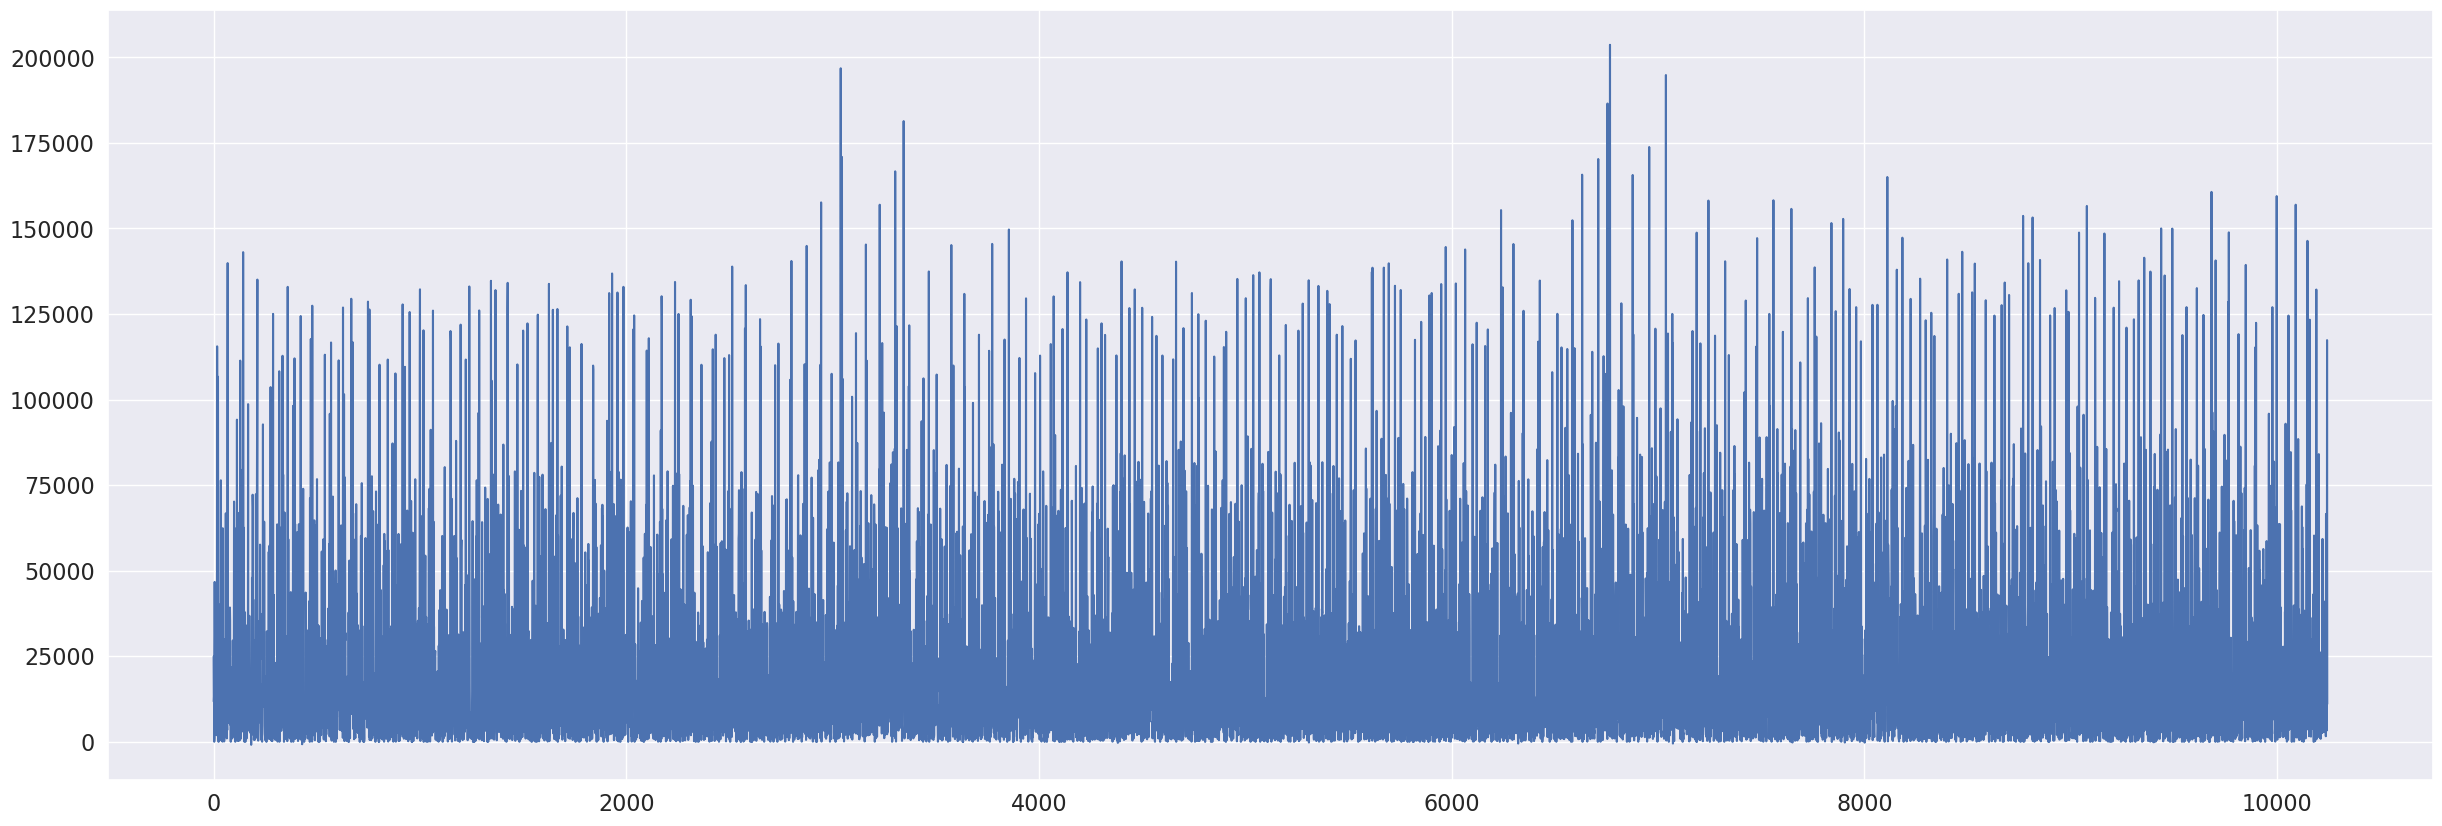

In [5]:
plt.rcParams['figure.figsize']=[30,10]

walmart_store_one = walmart_df[walmart_df['Store'] == 1]
walmart_store_one = walmart_store_one[['Date', 'Weekly_Sales']]
plt.plot(walmart_store_one['Weekly_Sales'])

In [6]:
walmart_store_one['Date'] = pd.to_datetime(walmart_store_one['Date'])

In [7]:
walmart_store_one.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10244 entries, 0 to 10243
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          10244 non-null  datetime64[ns]
 1   Weekly_Sales  10244 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 240.1 KB


### Resample Data by Day

In [8]:
walmart_store_one = walmart_store_one.set_index('Date').resample('D').mean()
walmart_store_one = walmart_store_one.reset_index()
walmart_store_one['Weekly_Sales'] = walmart_store_one['Weekly_Sales'].interpolate()

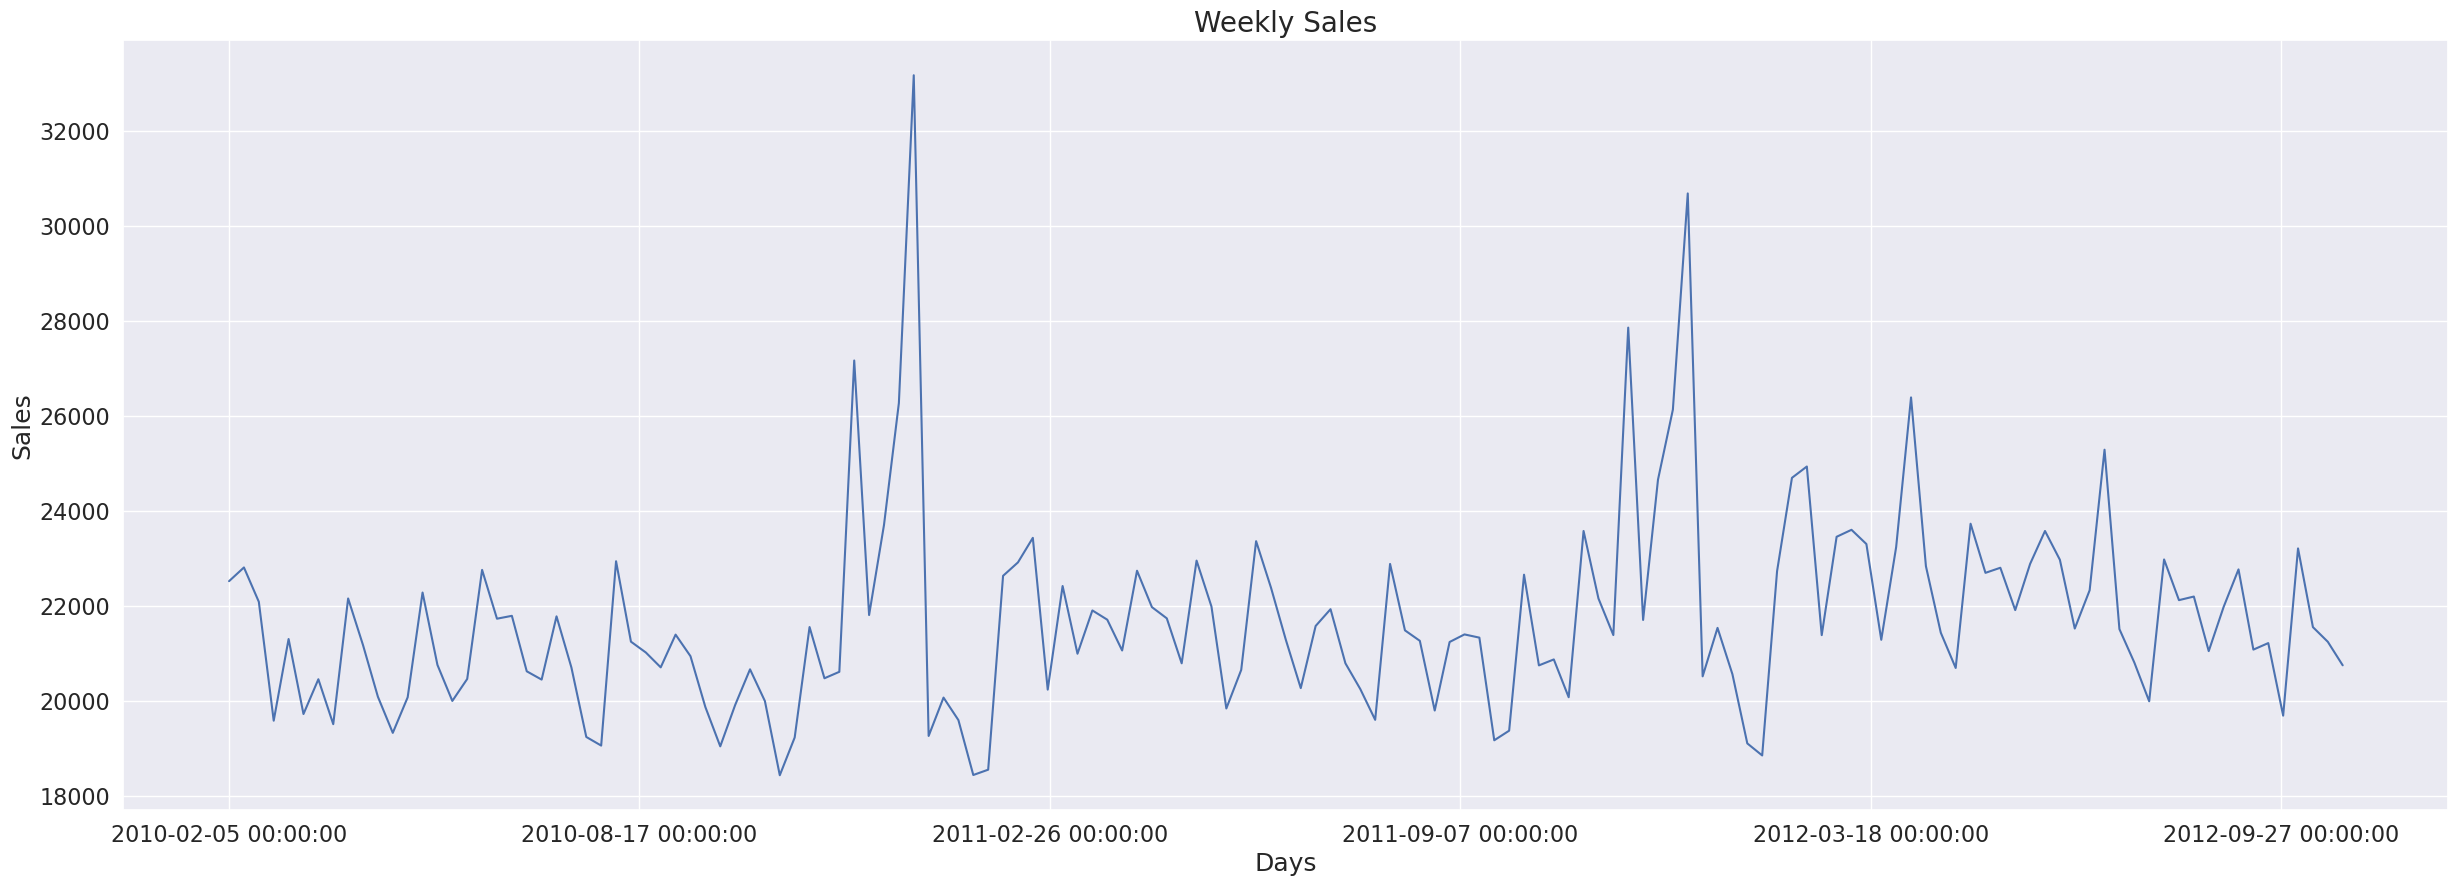

In [9]:
# Plot Resampled Weekly Sales Data
plt.plot(walmart_store_one['Weekly_Sales'])
plt.xticks(range(0, 1158, 193), walmart_store_one['Date'][range(0, 1158, 193)])
plt.xlabel('Days')
plt.ylabel('Sales')
plt.title('Weekly Sales')
plt.show()

### ETS

In [10]:
ets_df = walmart_store_one.copy()

ets_df['Date'] = pd.to_datetime(ets_df['Date'])
ets_df = ets_df.set_index('Date')

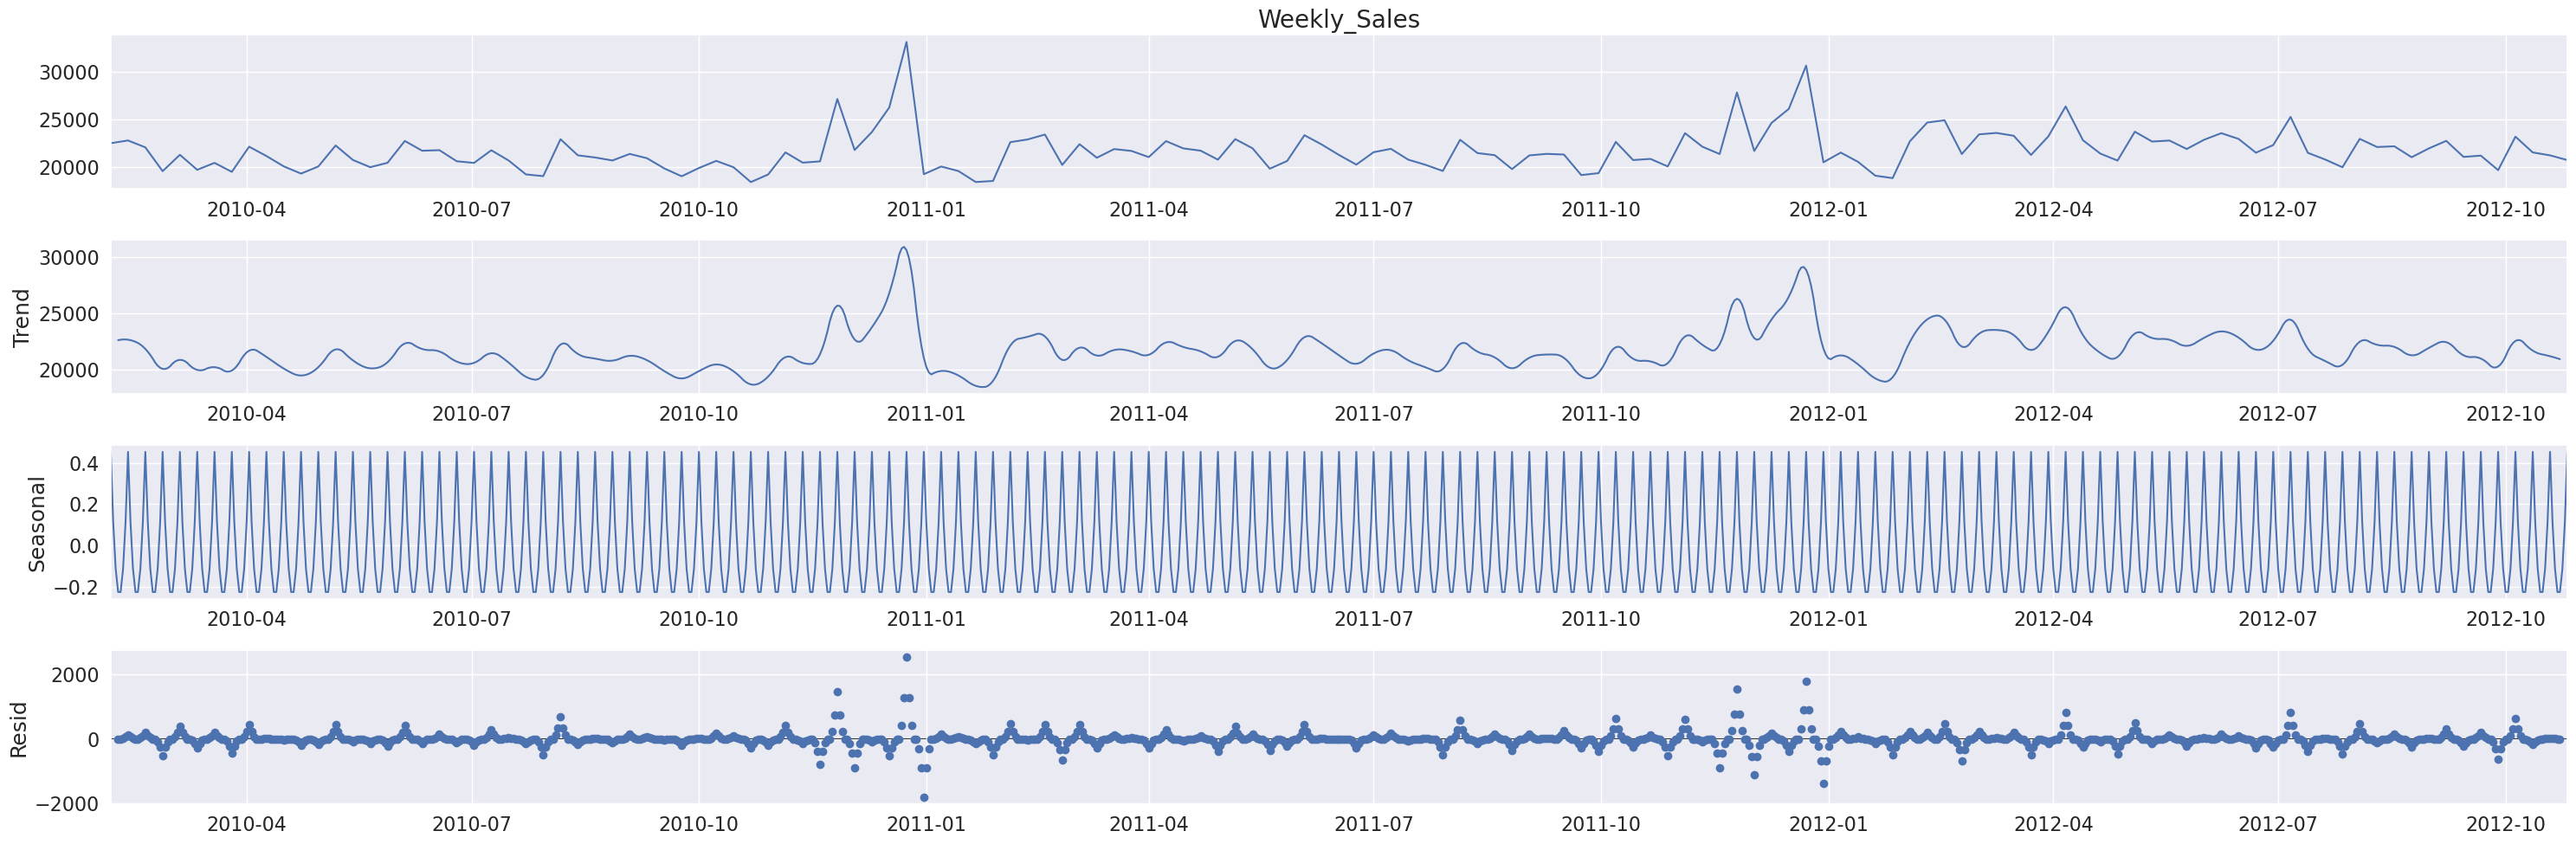

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ets_df['Weekly_Sales'], model='additive')

plt.rcParams['figure.figsize']=[30,10]
fig = result.plot()

### Train/Test Data

In [12]:
walmart_store_one['Year'] = walmart_store_one['Date'].dt.year

In [14]:
walmart_store_one['Year'].value_counts()

2011    365
2010    330
2012    300
Name: Year, dtype: int64

In [15]:
walmart_store_one_train = walmart_store_one.loc[((walmart_store_one['Year'] == 2010) | (walmart_store_one['Year'] == 2011))]
walmart_store_one_train = walmart_store_one_train.drop(['Year'], axis=1)

walmart_store_one_test = walmart_store_one.loc[(walmart_store_one['Year'] == 2012)]
walmart_store_one_test = walmart_store_one_test.drop(['Year'], axis=1)

In [18]:
walmart_store_one_train.shape, walmart_store_one_test.shape

((695, 2), (300, 2))

### TSFresh Feature Extraction

In [19]:
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters

In [20]:
def split_sequnces(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
      end_ix = i + n_steps
      if end_ix > len(sequences)-1:
        break
      seq_x, seq_y = sequences[i:end_ix], sequences[end_ix]
      X.append(seq_x)
      y.append(seq_y)
    return np.array(X), np.array(y)

In [31]:
n_steps = 10
columns = ['sale_' + str(k) for k in range(n_steps)]

X_train_splitted, y_train = split_sequnces(walmart_store_one_train['Weekly_Sales'], n_steps)

X_train_df = pd.DataFrame(X_train_splitted, columns=columns)
X_train_df['id'] = [i for i in range(685)]
X_train_df['date'] = walmart_store_one_train['Date'][n_steps:].values

In [ ]:
X_test_splitted, y_test = split_sequnces(walmart_store_one_test['Weekly_Sales'].reset_index(drop=True), n_steps)

X_test_df = pd.DataFrame(X_test_splitted, columns=columns)
X_test_df['id'] = [i for i in range(290)]
X_test_df['date'] = walmart_store_one_test['Date'][n_steps:].values

In [54]:
extraction_settings = MinimalFCParameters()
X_train = extract_features(X_train_df, column_id='id', column_sort='date', default_fc_parameters=extraction_settings)
X_train.shape

Feature Extraction: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


(685, 100)

In [55]:
extraction_settings = MinimalFCParameters()
X_test = extract_features(X_test_df, column_id='id', column_sort='date', default_fc_parameters=extraction_settings)
X_test.shape

Feature Extraction: 100%|██████████| 10/10 [00:01<00:00,  7.77it/s]


(290, 100)

### XGBRegressor

In [56]:
X_train = X_train.join(X_train_df).drop(['id', 'date'], axis=1)

In [58]:
from xgboost import XGBRegressor

reg = XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [60]:
X_test = X_test.join(X_test_df).drop(['id', 'date'], axis=1)

In [82]:
y_pred = reg.predict(X_test)
y_true = walmart_store_one_test['Weekly_Sales'][10:].reset_index(drop=True).values

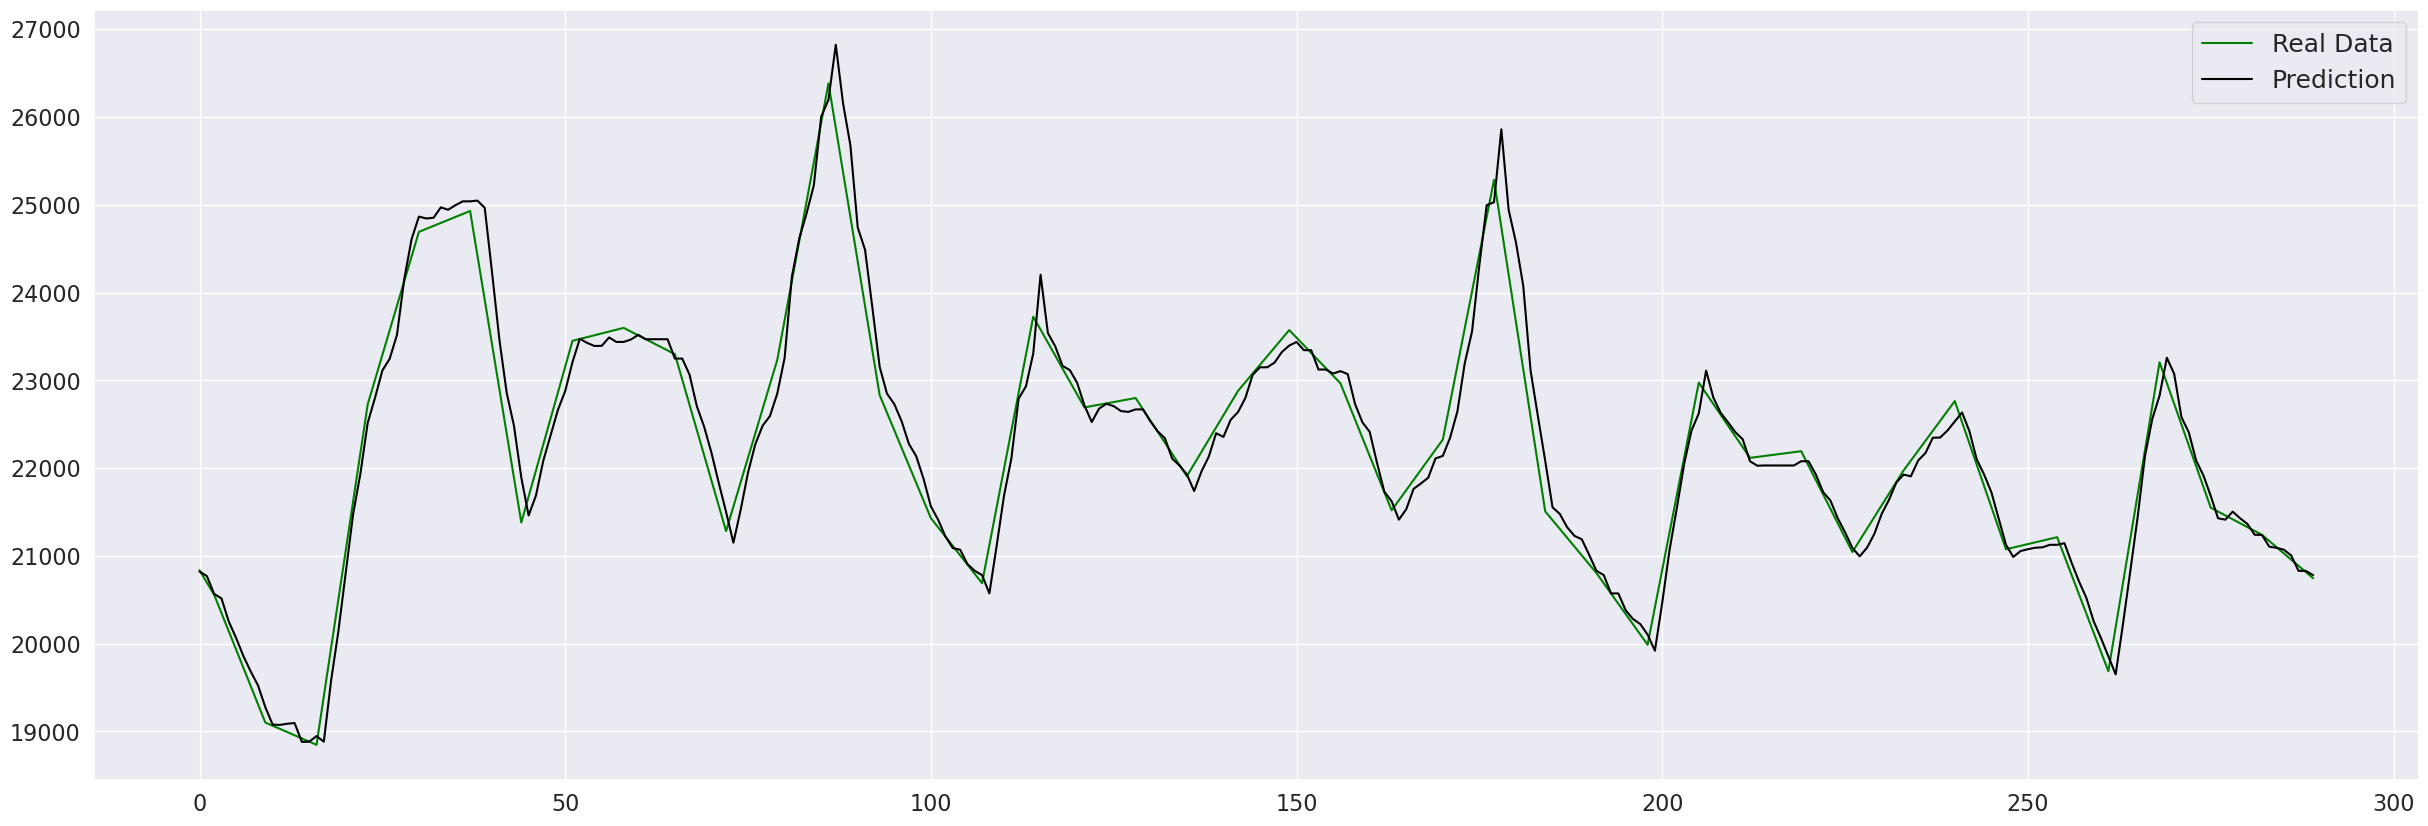

In [84]:
plt.plot(y_true, color='green', label='Real Data')
plt.plot(y_pred, color='black', label='Prediction')
plt.legend(loc='best')
plt.show()

### Anomaly Detection

In [89]:
residuals = pd.DataFrame(y_true - y_pred, columns=['error'])
UCL = residuals.abs().sum(axis=1).quantile(0.99)

In [102]:
anomalies_ind = residuals[residuals['error'].abs() > UCL].index

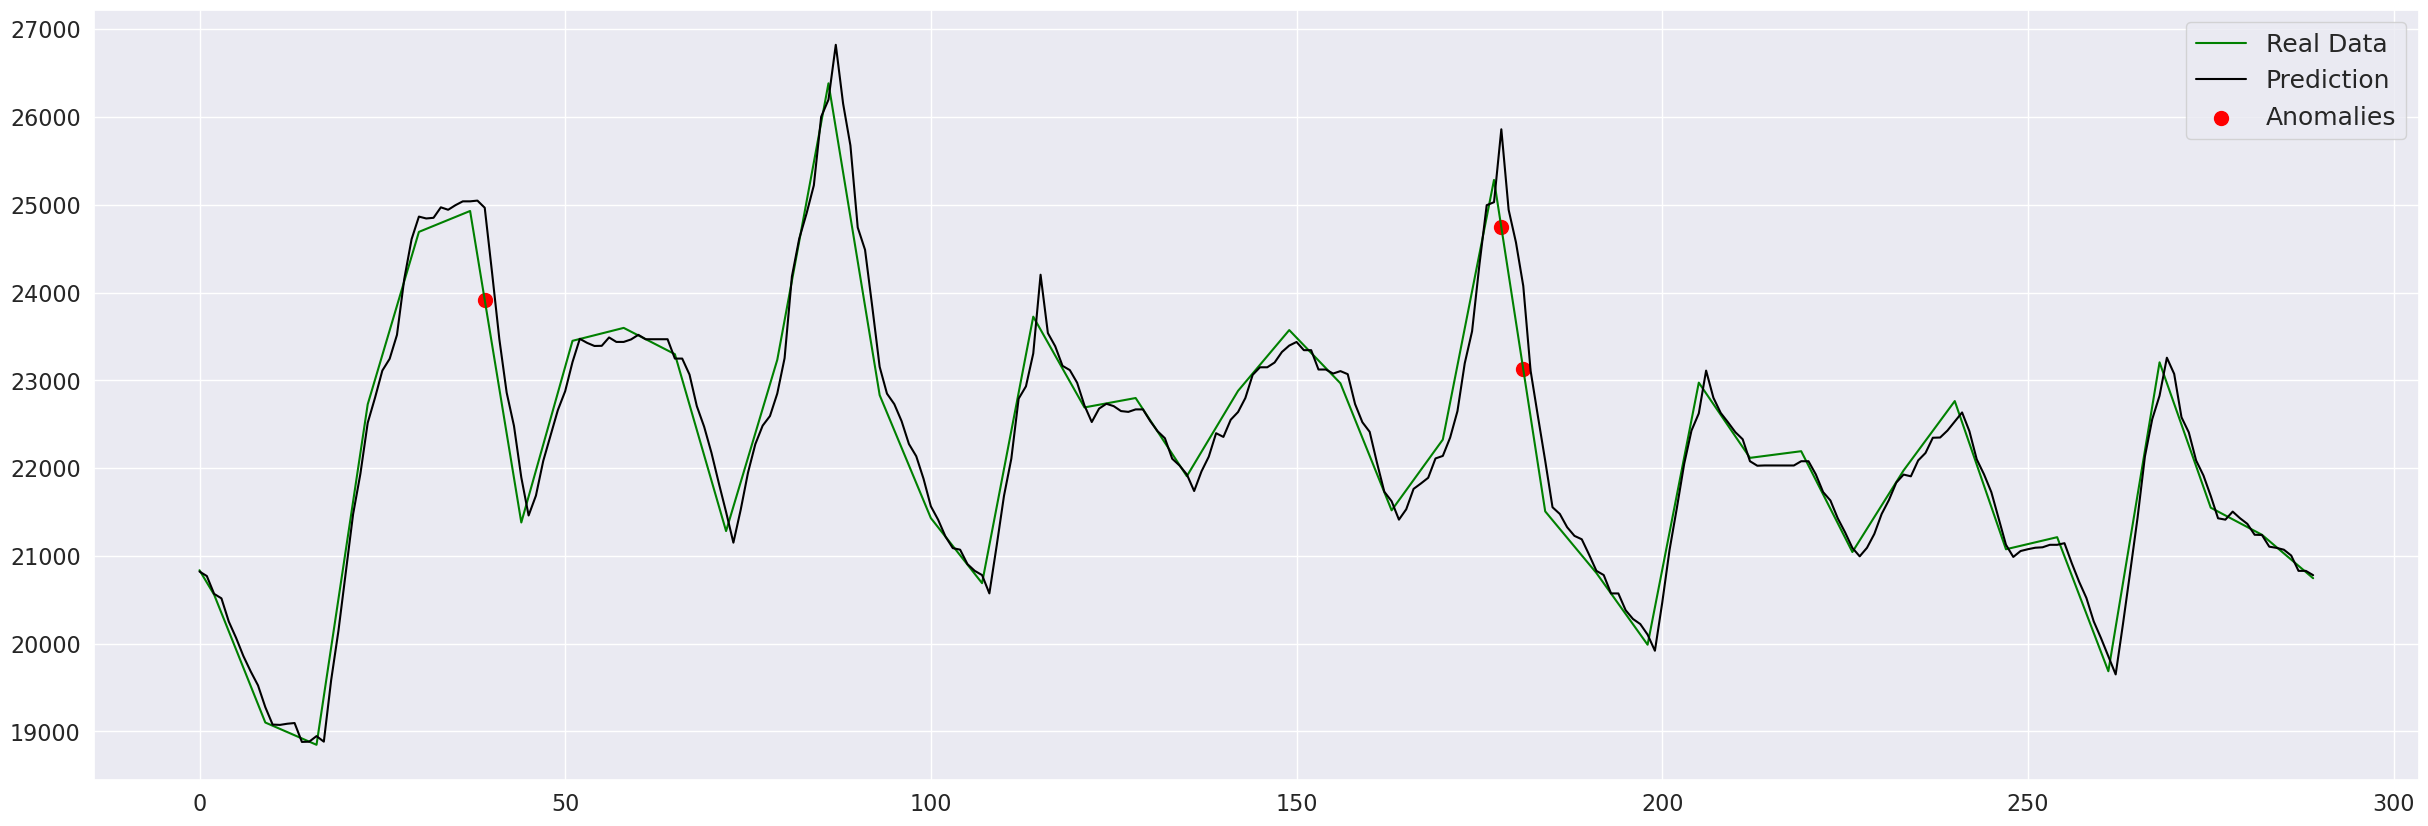

In [109]:
plt.plot(y_true, color='green', label='Real Data')
plt.plot(y_pred, color='black', label='Prediction')
plt.scatter(anomalies_ind, y_true[anomalies_ind], s=100, color='red', label='Anomalies')
plt.legend(loc='best')
plt.show()